need to launch src/extract_harws.py first

In [1]:
# imports
from copy import deepcopy
import numpy as np
from statistics import mean

import sys
sys.path.append('../src/')

from classification import get_stumps, get_scipy_selected_stumps
from evaluation import central_train_accuracy, central_test_accuracy, edges, central_loss, kalo_objective
from network import null_graph, get_alphas
from related_works import alternating_colearning, block_alternating_colearning
from optimization import gd_reg_local_FW, local_FW, global_regularized_local_FW, centralized_FW
from utils import load_harws, get_min_max

import matplotlib.pyplot as plt
%matplotlib inline

# Walking upstairs vs walking downstairs

In [3]:
# set graph of nodes with local personalized data
NB_ITER = 1000
n = 1122

MU = 10
BETA = 1

X, Y, X_test, Y_test, K, max_nb_instances = load_harws(path="../datasets/", walking=True)
D = X[0].shape[1]

# get nodes
nodes = null_graph(X, Y, X_test, Y_test, K, max_nb_instances)

# set monitors for optimization analysis
monitors = {
    'train-accuracy': [central_train_accuracy, []],
    'test-accuracy': [central_test_accuracy, []],
    'loss': [central_loss, []],
#     'edges': [edges, []]
}

# get weak classifiers
vmin, vmax = get_min_max(X)
base_clfs = get_stumps(n=n, d=D, min_v=vmin, max_v=vmax)

results = {}

In [4]:
centralized_nodes = deepcopy(nodes)
centralized_FW(centralized_nodes, base_clfs, beta=BETA, nb_iter=NB_ITER, monitors={})
results["Global-Adaboost"] = {}
results["Global-Adaboost"]["train-accuracy"] = central_train_accuracy(centralized_nodes)
results["Global-Adaboost"]["test-accuracy"] = central_test_accuracy(centralized_nodes)

local_nodes = deepcopy(nodes)
local_FW(local_nodes, base_clfs, beta=BETA, nb_iter=NB_ITER, monitors={})
results["Local-Adaboost"] = {}
results["Local-Adaboost"]["train-accuracy"] = central_train_accuracy(local_nodes)
results["Local-Adaboost"]["test-accuracy"] = central_test_accuracy(local_nodes)

In [5]:
results["Perso-linear-Learned-$\kappa=5$"], clf_colearning = block_alternating_colearning(K, X, Y, X_test, Y_test, D, NB_ITER, 
    mu=0.1, la=1000, kappa=5, pace_gd=200, max_iter_gd=100, max_samples_per_node=max_nb_instances, checkevery=10)

99
99
99
99
99
99


In [6]:
MU, LA = 0.001, 0.1
STEP = 200

monitors = {
    'train-accuracy': [central_train_accuracy, []],
    'test-accuracy': [central_test_accuracy, []],
}

gd_nodes = deepcopy(nodes)
results["Dada-Learned-$\kappa=5$"] = gd_reg_local_FW(gd_nodes, base_clfs, gd_method={"name":"block_kalo", "pace_gd": STEP, 
                    "args":(MU, LA, 5, 100)}, beta=BETA, mu=MU, nb_iter=1000, monitors=monitors, checkevery=10)

../src/optimization.py:50: RuntimeWarning: divide by zero encountered in log
  return d.dot(l) + (mu / 2) * (w.dot(z) - np.log(d).sum() + la * (mu / 2) * w.dot(w))
../src/optimization.py:146: RuntimeWarning: divide by zero encountered in true_divide
  grad = l[rnd_j].dot(S_block) + (mu / 2) * (z[idx_block] - (1. / d_block).dot(S_block) + 2 * la * (mu / 2) * new_w[idx_block])
../src/optimization.py:47: RuntimeWarning: invalid value encountered in less
  if np.any(d < 0):
../src/optimization.py:149: RuntimeWarning: invalid value encountered in less
  new_w[new_w < 0] = 0


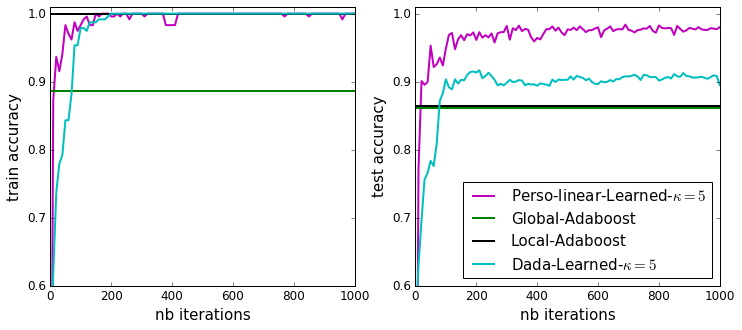

In [7]:
plt.figure(1, figsize=(12, 5))

colors = {
    "Global-Adaboost": "g",
    "Local-Adaboost": "k",
    "Perso-linear-Learned-$\kappa=5$": "m", 
    "Dada-Learned-$\kappa=5$": "c",    
}

max_iter = NB_ITER
plt.subplot(121)
plt.xlabel('nb iterations', fontsize=15)
plt.ylabel('train accuracy', fontsize=15)
plt.xlim(0, max_iter)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylim(0.6, 1.01)

for k, r_list in results.items():
    if k == "Perso-linear-Learned":
        continue
    try:
        plt.plot([i*10 for i in range(len(r_list))], [r['train-accuracy'] for r in r_list], label='_nolegend_', color=colors[k], linewidth=2)
    except:
        plt.plot(range(max_iter+1), [r_list['train-accuracy']]*(max_iter+1), label='{}'.format(k), color=colors[k], linewidth=2)
# plt.legend(loc='lower right', fontsize=17)


plt.subplot(122)
plt.xlabel('nb iterations', fontsize=15)
plt.ylabel('test accuracy', fontsize=15)
plt.xlim(0, max_iter)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylim(0.6, 1.01)

for k, r_list in results.items():
    if k == "Perso-linear-Learned":
        continue
    try:
        plt.plot([i*10 for i in range(len(r_list))], [r['test-accuracy'] for r in r_list], label=k, color=colors[k], linewidth=2)
    except:
        plt.plot(range(max_iter+1), [r_list['test-accuracy']]*(max_iter+1), label=k, color=colors[k], linewidth=2)

plt.legend(loc='lower right', fontsize=15)
# plt.legend(bbox_to_anchor=(1.6, 1), fontsize=18)

# plt.savefig("harws-acc.pdf", bbox_inches="tight")

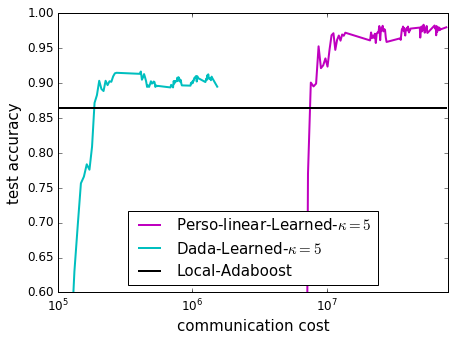

In [8]:
from math import log

def expected_new_nodes(nb_nodes, kappa, nb_iter):
    return kappa * ((nb_nodes**2 - nb_nodes - kappa) / (nb_nodes * (nb_nodes - 1)))**(nb_iter - 1)

Z = 32
cost = min(STEP / K, n)

# test accuracy vs communication
linear_com = 2*D*Z*10
regularized_com = [20 *(Z + log(n))*10 for r in results['Dada-Learned-$\kappa=5$']]

x_linear = [linear_com*i for i in range(len(results['Perso-linear-Learned-$\kappa=5$']))]
x_dada = [sum(regularized_com[:i]) for i in range(len(results['Dada-Learned-$\kappa=5$']))]

lin_iter = [99] * 6
dada_iter = [99] * 6

for i, it in enumerate(lin_iter):

    for j in range(i*20, len(x_linear)):
        x_linear[j] += 2 * Z * 5 * it + (D + 1) * Z * sum([expected_new_nodes(K, 5, a) for a in range(it)])

for i, it in enumerate(dada_iter):

    for j in range(i*20, len(x_dada)):
        x_dada[j] += 2 * Z * 5 * it  + (cost + 1) * Z * sum([expected_new_nodes(K, 5, a) for a in range(it)])
        
plt.figure(1, figsize=(7, 5))

plt.xlabel('communication cost', fontsize=15)
plt.ylabel('test accuracy', fontsize=15)

plt.plot(x_linear, [r['test-accuracy'] for r in results['Perso-linear-Learned-$\kappa=5$']], label='Perso-linear-Learned-$\kappa=5$', color=colors['Perso-linear-Learned-$\kappa=5$'], linewidth=2)
plt.plot(x_dada, [r['test-accuracy'] for r in results['Dada-Learned-$\kappa=5$']], label='Dada-Learned-$\kappa=5$', color=colors['Dada-Learned-$\kappa=5$'], linewidth=2)
plt.plot([0, max(max(x_dada), max(x_linear))], [results["Local-Adaboost"]["test-accuracy"]]*2, label='Local-Adaboost', color=colors['Local-Adaboost'], linewidth=2)

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlim(0, max(max(x_dada), max(x_linear)))
plt.ylim(0.6, 1)
plt.xlim(1e5, 8e7)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xscale('symlog')

plt.legend(loc="lower center", fontsize=15)

plt.savefig("harws-comm.pdf", bbox_inches="tight")